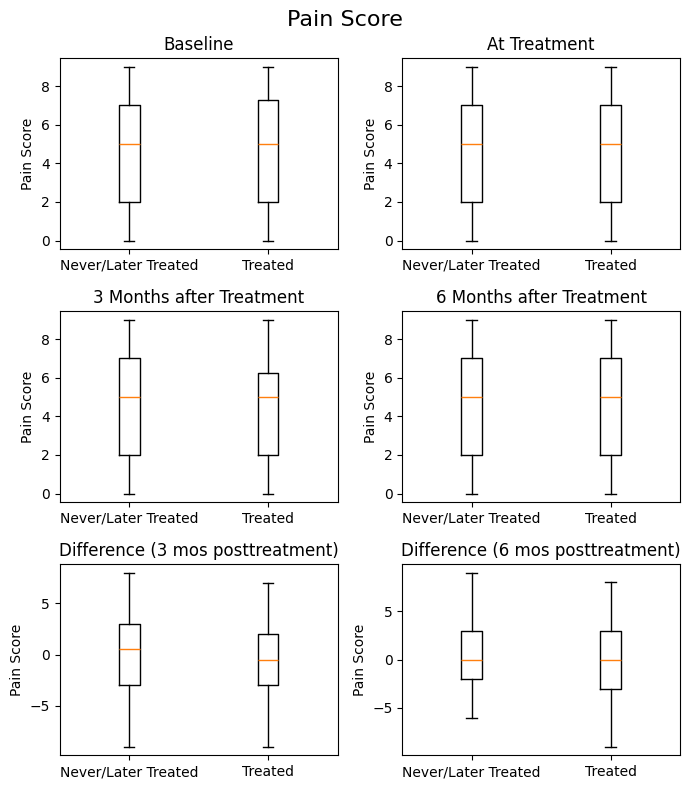

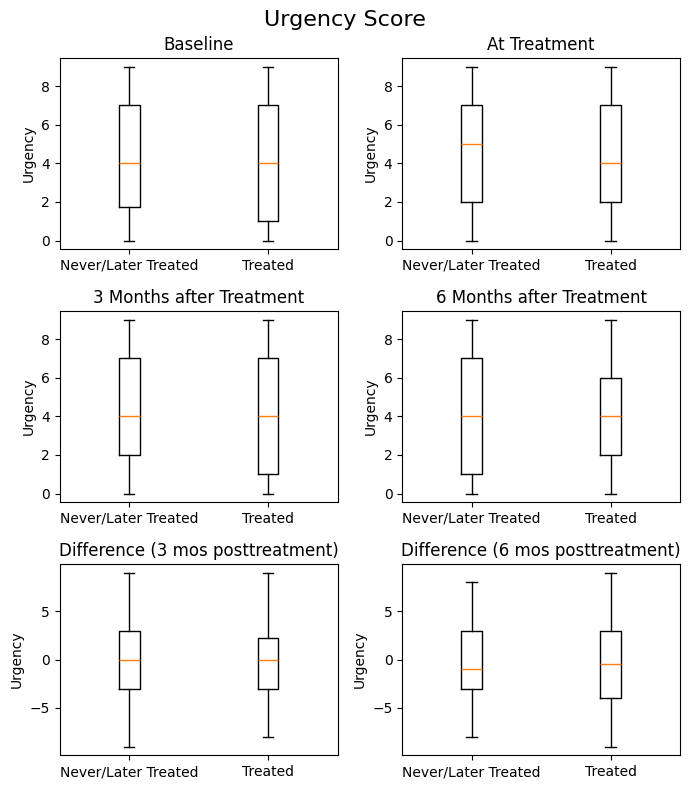

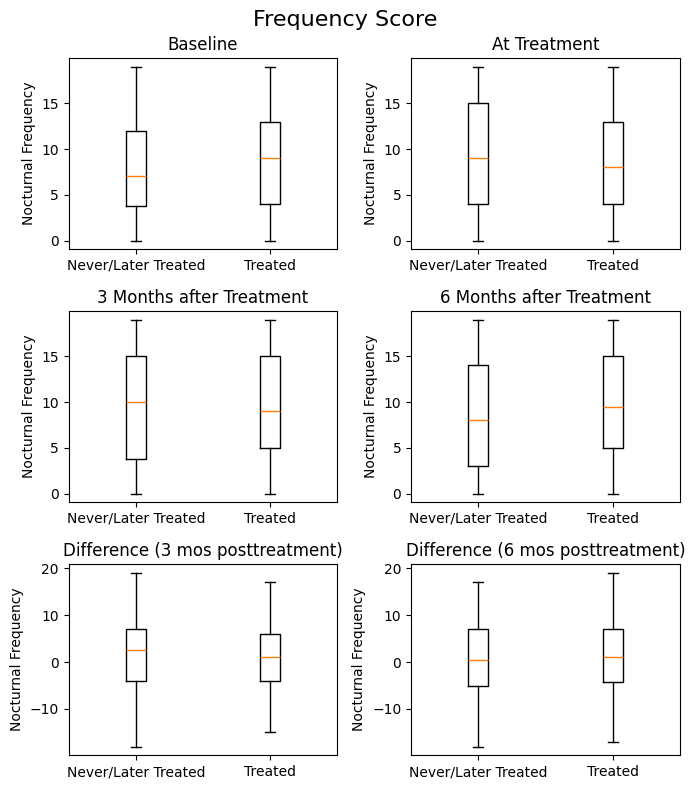

Wilcoxon signed-rank test: statistic=2229.0, p-value=0.0286
Sensitivity Analysis:
Gamma=1.5: p-range=(0.0191, 0.0429)
Gamma=2: p-range=(0.0143, 0.0573)
Gamma=3: p-range=(0.0095, 0.0859)


In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import mahalanobis
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(28)

# Constants
n_patients = 400
BOX_TITLES = [
    'Baseline', 'At Treatment', '3 Months after Treatment', 
    '6 Months after Treatment', 'Difference (3 mos posttreatment)', 
    'Difference (6 mos posttreatment)'
]
BOX_LABELS = ['Never/Later Treated', 'Treated']

# Generate synthetic data
df = pd.DataFrame({
    'patient_id': np.arange(n_patients),
    'gender': np.random.choice(['M', 'F'], n_patients),
    'treatment_time': np.random.choice([6, 9, 12, np.nan], n_patients),
    'pain_baseline': np.random.randint(0, 10, n_patients),
    'urgency_baseline': np.random.randint(0, 10, n_patients),
    'frequency_baseline': np.random.randint(0, 20, n_patients),
    'pain_treatment': np.random.randint(0, 10, n_patients),
    'urgency_treatment': np.random.randint(0, 10, n_patients),
    'frequency_treatment': np.random.randint(0, 20, n_patients),
    'pain_3m': np.random.randint(0, 10, n_patients),
    'urgency_3m': np.random.randint(0, 10, n_patients),
    'frequency_3m': np.random.randint(0, 20, n_patients),
    'pain_6m': np.random.randint(0, 10, n_patients),
    'urgency_6m': np.random.randint(0, 10, n_patients),
    'frequency_6m': np.random.randint(0, 20, n_patients),
    'outcome': np.random.normal(0, 1, n_patients),
})

# Split into treated and not treated
treated = df[df['treatment_time'].notna()].copy()
not_treated = df[df['treatment_time'].isna()].copy()

# Compute Mahalanobis distance for matching
def mahalanobis_distance(x, y, cov_inv):
    return mahalanobis(x, y, cov_inv)

cov_cols = ['pain_baseline', 'urgency_baseline', 'frequency_baseline',
            'pain_treatment', 'urgency_treatment', 'frequency_treatment']
cov_matrix = df[cov_cols].cov().values
cov_inv = np.linalg.inv(cov_matrix)

# Perform greedy matching
matched_pairs = []
used_controls = set()

for idx, treated_patient in treated.iterrows():
    eligible_controls = not_treated[~not_treated.index.isin(used_controls)]
    distances = []
    
    for c_idx, control_patient in eligible_controls.iterrows():
        x = treated_patient[cov_cols].values
        y = control_patient[cov_cols].values
        d = mahalanobis_distance(x, y, cov_inv)
        distances.append((c_idx, d))
    
    if distances:
        distances.sort(key=lambda x: x[1])
        closest = distances[0]
        matched_pairs.append((treated_patient['patient_id'], closest[0]))
        used_controls.add(closest[0])

# Create matched dataset
matched_treated = treated[treated['patient_id'].isin([p[0] for p in matched_pairs])].copy()
matched_not_treated = not_treated.loc[[p[1] for p in matched_pairs]].copy()

# Compute differences for each matched pair
matched_treated.loc[:, "pain_diff_3m"] = matched_treated["pain_3m"] - matched_treated["pain_baseline"]
matched_treated.loc[:, "pain_diff_6m"] = matched_treated["pain_6m"] - matched_treated["pain_baseline"]
matched_not_treated["pain_diff_3m"] = matched_not_treated["pain_3m"] - matched_not_treated["pain_baseline"]
matched_not_treated["pain_diff_6m"] = matched_not_treated["pain_6m"] - matched_not_treated["pain_baseline"]

matched_treated.loc[:, "urgency_diff_3m"] = matched_treated["urgency_3m"] - matched_treated["urgency_baseline"]
matched_treated.loc[:, "urgency_diff_6m"] = matched_treated["urgency_6m"] - matched_treated["urgency_baseline"]
matched_not_treated["urgency_diff_3m"] = matched_not_treated["urgency_3m"] - matched_not_treated["urgency_baseline"]
matched_not_treated["urgency_diff_6m"] = matched_not_treated["urgency_6m"] - matched_not_treated["urgency_baseline"]

matched_treated.loc[:, "frequency_diff_3m"] = matched_treated["frequency_3m"] - matched_treated["frequency_baseline"]
matched_treated.loc[:, "frequency_diff_6m"] = matched_treated["frequency_6m"] - matched_treated["frequency_baseline"]
matched_not_treated["frequency_diff_3m"] = matched_not_treated["frequency_3m"] - matched_not_treated["frequency_baseline"]
matched_not_treated["frequency_diff_6m"] = matched_not_treated["frequency_6m"] - matched_not_treated["frequency_baseline"]

# Function to create a combined figure with 6 box plots
def plot_combined_boxplots(data_treated, data_not_treated, measure_names, title, label):
    fig, axes = plt.subplots(3, 2, figsize=(7, 8))
    fig.suptitle(title, fontsize=16)
    
    for i, measure in enumerate(measure_names):
        row, col = divmod(i, 2)
        axes[row, col].boxplot([data_not_treated[measure], data_treated[measure]], labels=BOX_LABELS)
        axes[row, col].set_title(BOX_TITLES[i])
        axes[row, col].set_ylabel(label)

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

# Generate combined boxplots for Pain, Urgency, and Frequency
plot_combined_boxplots(
    matched_treated, matched_not_treated, 
    ['pain_baseline', 'pain_treatment', 'pain_3m', 'pain_6m', 'pain_diff_3m', 'pain_diff_6m'], 
    "Pain Score", "Pain Score"
)

plot_combined_boxplots(
    matched_treated, matched_not_treated, 
    ['urgency_baseline', 'urgency_treatment', 'urgency_3m', 'urgency_6m', 'urgency_diff_3m', 'urgency_diff_6m'], 
    "Urgency Score", "Urgency"
)

plot_combined_boxplots(
    matched_treated, matched_not_treated, 
    ['frequency_baseline', 'frequency_treatment', 'frequency_3m', 'frequency_6m', 'frequency_diff_3m', 'frequency_diff_6m'], 
    "Frequency Score", "Nocturnal Frequency"
)

# Wilcoxon test
treated_outcomes = matched_treated['outcome'].values
not_treated_outcomes = matched_not_treated['outcome'].values
stat, p_value = wilcoxon(treated_outcomes, not_treated_outcomes)
print(f"Wilcoxon signed-rank test: statistic={stat}, p-value={p_value:.4f}")

# Sensitivity Analysis
def sensitivity_analysis(pairs, gamma_values):
    original_p = wilcoxon(treated_outcomes, not_treated_outcomes).pvalue
    p_values = [original_p]
    for gamma in gamma_values:
        upper_p = original_p * gamma
        lower_p = original_p / gamma
        p_values.append((lower_p, upper_p))
    return p_values

gamma_values = [1.5, 2, 3]
sensitivity_results = sensitivity_analysis(matched_pairs, gamma_values)
print("Sensitivity Analysis:")
for gamma, p in zip(gamma_values, sensitivity_results[1:]):
    print(f"Gamma={gamma}: p-range=({p[0]:.4f}, {p[1]:.4f})")